In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import networkx as nx
from bidict import bidict
import types
%matplotlib inline

In [2]:
pathContent = Path("./WebKB/content/")
pathCites = Path("./WebKB/cites/")
contentPath = {pC.stem : pC for pC in pathContent.glob("*.content")}
dataPath = {k : (v, (pathCites / (k+'.cites'))) for k,v in contentPath.items() if (pathCites / (k+'.cites')).is_file()}

In [3]:
def readContent(path):
    r = pd.read_csv(path, index_col = 0, header=None, delim_whitespace=True, prefix='F', )
    return r.rename(columns={r.columns[-1]:"class"}).rename_axis("node")
def readCites(path):
    return pd.read_csv(path, names=["source",'target'], delim_whitespace=True)

In [4]:
data = {k : (readContent(vc), nx.DiGraph(readCites(vci))) for k,(vc,vci) in dataPath.items()}

In [5]:
for k in data:
    nx.set_node_attributes(data[k][1], data[k][0]['class'].to_dict(), 'class')

In [6]:
def trainer(self, x, y, ite = 500, batchSize = 100):
    ml = torch.nn.MSELoss()
    opt = optim.SGD(self.parameters(), lr=1e-3)
    
    for i in range(ite):
        perm = torch.randperm(x.size()[0])
        
        xv = autograd.Variable(x[perm[:batchSize]])
        yv = autograd.Variable(y[perm[:batchSize]])
        f = self.forward(xv)
        loss = ml.forward(f, yv.float())
        loss.backward()
        opt.step()
    
        if histo :
            histo[0].append(loss.data.mean())
            ypred = torch.max(f, 1)[1]
            histo[1].append(torch.eq(ypred.data, torch.max(yv, 1)[1].data).float().mean())

def triLayerNN(inn, out):
    r = nn.Sequential(nn.Linear(inn,inn), nn.Linear(inn,inn), nn.Linear(inn,out), torch.nn.Sigmoid())
    r.train = types.MethodType(trainer, r)
    return r


In [7]:
def createBiDictLabelToIndices(labels):
    r = bidict()
    for i, l  in enumerate(labels):
        r[l] = i
    return r

class LabelToOneHot(object):
    def __init__(self, labels):
        self.d = createBiDictLabelToIndices(labels)
    
    def toOneHot(self, labels):
        '''
            :param labels: the label you want to be transform into onehot
            :labels type: a list a label
            :rtype: a tensor len(labels)*numberOfAllLabels
        '''
        r = torch.zeros(len(labels), len(self.d)).long()
        ind = torch.LongTensor([[self.d[l] for l in labels]]).t()
        return r.scatter_(1, ind, 1)
    
    def fromOneHot(self, tensor):
        return [self.d.inv[i] for i in tensor.max(1)[1].numpy()]
    
    def dictLabelToList(self, dic):
        r = [0 for i in range(len(self.d))]
        for k,v in dic.items():
            r[self.d[k]] = v
        return r
    
    def __len__(self):
        return len(self.d)

In [8]:
class ICA(object):
    def __init__(self, data, graph, modelGen, agg):
        '''
            :param data: the data to train the model
            :data type: panda data frame with the node name as index and at least a column "class", the rest are feature column
            with name beginning by 'F'
            unknown label class in data are None
            :param graph: the graph 
            :graph type: networkx graph of node->node
            :param modelGen: a model generator that generate a model that implement a train function, 
            the argument of the modelGen function are : number of in dimensions, number of out dimensions
            :param agg: a aggregation function that take a node, a graph, and return a dict of class->agregation value
        '''
        self.data = data.join(data["class"].notna().rename('isOriginalClass'))
        self.graph = graph
        self.featCol = [c for c in data if c.startswith('F')]
        self.embeder = LabelToOneHot(pd.unique(self.data[self.data.isOriginalClass]["class"]))
        self.model = modelGen(len(self.featCol) + len(self.embeder), len(self.embeder))
        self.agg = agg
    
    def train(self, ite = 500, batchSize = 100):
        dtf = self.data[self.data.isOriginalClass]
        dtagg = pd.DataFrame([self.embeder.dictLabelToList(self.agg(i, self.graph)) for i in dtf.index],\
                             index = dtf.index).rename(columns = dict(self.embeder.d.inv)).rename_axis("node")
        dt = dtf.join(dtagg)
        x = torch.Tensor(dt[self.featCol + list(self.embeder.d)].values)
        y = self.embeder.toOneHot(dt["class"])
        self.model.train(x, y, ite, batchSize)
    
    def infer(self):
        dtf = self.data[~ self.data.isOriginalClass].sample(frac=1)
        dtagg = pd.DataFrame([self.embeder.dictLabelToList(self.agg(i, self.graph)) for i in dtf.index],\
                             index = dtf.index).rename(columns = dict(self.embeder.d.inv)).rename_axis("node")
        dt = dtf.join(dtagg)
        x = autograd.Variable(torch.Tensor(dt[self.featCol+list(self.embeder.d)].values))
        y = self.model(x).data
        clas = self.embeder.fromOneHot(y)
        self.data.loc[dt.index,'class'] = clas
    
    def stabilize(self, maxIter = 1000, verbose = True):
        for i in range(maxIter):
            if verbose and i%(maxIter/10) == 0 : print("Iteration :", i)
            pre = self.data[~self.data.isOriginalClass]["class"]
            self.infer()
            if histo :
                histo.append(pre[pre == self.data[~self.data.isOriginalClass]["class"]].shape[0])
            if (pre == self.data[~self.data.isOriginalClass]["class"]).all():
                if verbose : print("Fixed point found, end")
                break

In [9]:
def aggcount(node, graph):
    r = {}
    for n in graph[node]:
        r[graph.node[n]['class']] = r.get(graph.node[n]['class'], 0) + 1
    return r

In [10]:
d = data['cornell'][0].copy(True)
d.loc[d.sample(frac=0.2).index, "class"] = None
ica = ICA(d, data['cornell'][1], triLayerNN, aggcount)

In [11]:
histo = [[],[]]

In [12]:
ica.train()

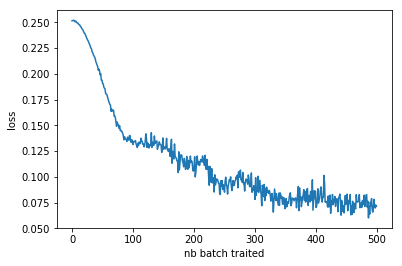

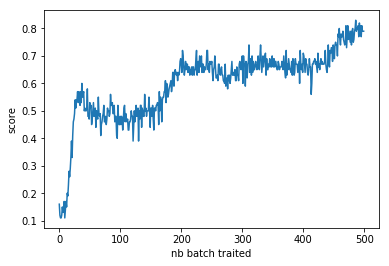

In [13]:
plt.plot(histo[0])
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(histo[1])
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

Iteration : 0
Fixed point found, end


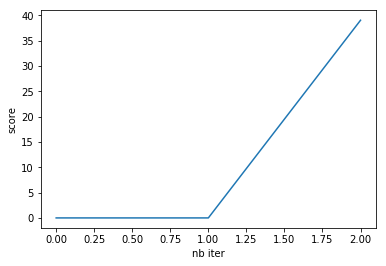

In [14]:
histo = [0]
ica.stabilize()
plt.plot(histo)
plt.ylabel('score')
plt.xlabel('nb iter')
plt.show()

In [15]:
d = data['cornell'][0].loc[ica.data[~ica.data.isOriginalClass].index]
print("Score :", d[d['class'] == ica.data[~ica.data.isOriginalClass]["class"]].shape[0],"/",\
      d.shape[0])

Score : 22 / 39


cornell


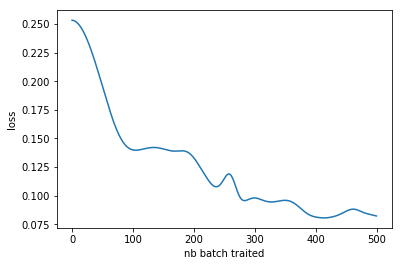

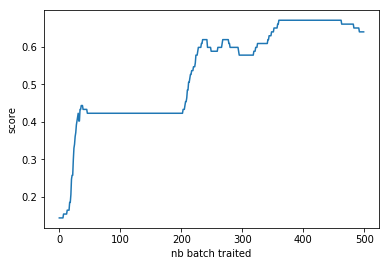

Iteration : 0
Fixed point found, end


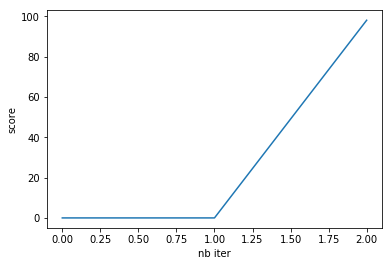

Score : 0 / 98
texas


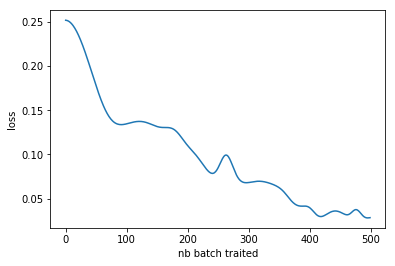

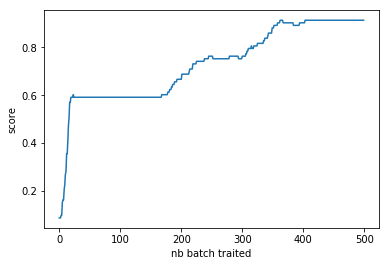

Iteration : 0
Fixed point found, end


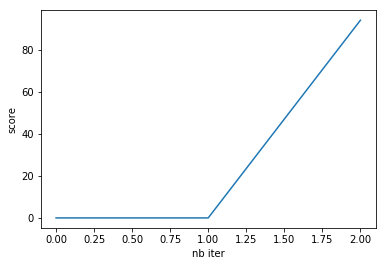

Score : 0 / 94
washington


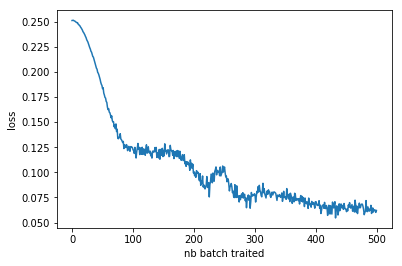

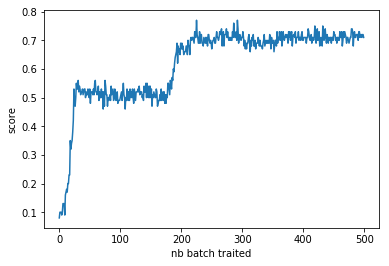

Iteration : 0
Fixed point found, end


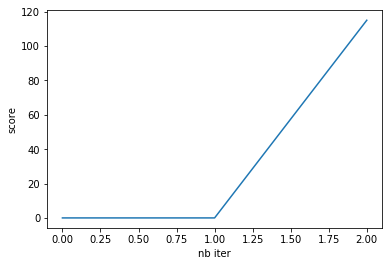

Score : 0 / 115
wisconsin


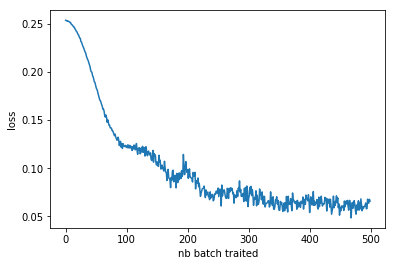

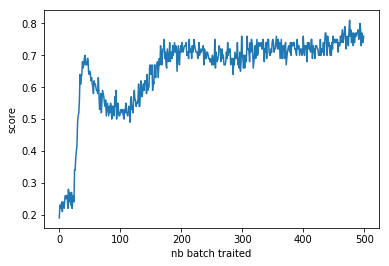

Iteration : 0
Fixed point found, end


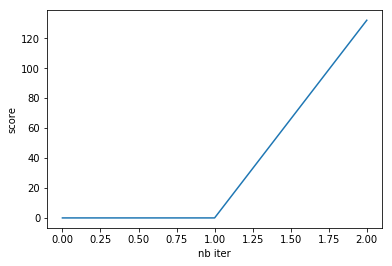

Score : 0 / 132


In [16]:
for k,(d,g) in data.items():
    print(k)
    d = d.copy(True)
    d.loc[d.sample(frac=0.5).index, "class"] = None
    ica = ICA(d, g, triLayerNN, aggcount)
    histo = [[],[]]
    ica.train()
    plt.plot(histo[0])
    plt.ylabel('loss')
    plt.xlabel('nb batch traited')
    plt.show()
    plt.plot(histo[1])
    plt.ylabel('score')
    plt.xlabel('nb batch traited')
    plt.show()
    histo = [0]
    ica.stabilize()
    plt.plot(histo)
    plt.ylabel('score')
    plt.xlabel('nb iter')
    plt.show()
    d2 = d.loc[ica.data[~ica.data.isOriginalClass].index]
    print("Score :", d2[d2['class'] == ica.data[~ica.data.isOriginalClass]["class"]].shape[0],"/",\
      d2.shape[0])